In [1]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from typing import Annotated, List
from dotenv import load_dotenv
import os

In [2]:
load_dotenv()

openai_model = os.getenv("OPENAI_MODEL", "gpt-4o-mini")

In [3]:
# LangSmith 설정을 위한 임포트
from langsmith import Client

# 환경 변수 확인 (디버깅용)
# LangSmith 트레이싱이 환경 변수로 활성화되어 있으면 자동으로 작동합니다
print(f"LANGSMITH_TRACING: {os.getenv('LANGSMITH_TRACING')}")
print(f"LANGSMITH_PROJECT: {os.getenv('LANGSMITH_PROJECT')}")

# LangSmith 클라이언트 초기화
client = Client(
    api_url=os.getenv("LANGSMITH_ENDPOINT"),
    api_key=os.getenv("LANGSMITH_API_KEY")
)

LANGSMITH_TRACING: true
LANGSMITH_PROJECT: pr-upbeat-escalator-85


In [4]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [5]:
from langchain_community.tools.tavily_search import TavilySearchResults

search_tool  = TavilySearchResults(max_results=2)
# tool.invoke("LangGraph에서 '노드'란 무엇인가요?")

In [6]:
from langchain_core.tools import tool
from langgraph.types import interrupt

@tool
def human_assist(query):
    """Human assist tool"""
    human_response = interrupt({"query": query})
    return human_response["data"]

In [7]:
llm = ChatOpenAI(model=openai_model)
tools = [search_tool, human_assist]
llm_with_tools = llm.bind_tools(tools)

In [8]:
def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

In [9]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [10]:
from langgraph.prebuilt import ToolNode, tools_condition

tool_node = ToolNode(tools)

workflow = StateGraph(State)

workflow.add_node("chatbot", chatbot)
workflow.add_node("tools", tool_node)
workflow.add_conditional_edges("chatbot", tools_condition)
workflow.add_edge("tools", "chatbot")
workflow.add_edge(START, "chatbot")

graph = workflow.compile(checkpointer=memory)

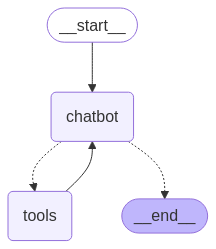

In [11]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
config = {"configurable": {"thread_id": "user123"}}

#config는 워크플로우에 필요한 어떤 정보든 포함시킬 수 있습니다.
# config = {
#     "configurable": {
#         "thread_id": "user123",
#         "user_name": "홍길동",
#         "language_preference": "korean",
#         "session_start_time": "2025-04-12T10:30:00",
#         "model_settings": {
#             "temperature": 0.7,
#             "top_p": 0.95
#         },
#         "custom_data": {
#             "user_preferences": ["tech", "science", "news"],
#             "subscription_level": "premium"
#         }
#     }
# }

In [13]:
user_input1 = "AI 에이전트 개발을 위한 LangGraph의 특징에 대해 설명해주세요."
state1 = {"messages": [HumanMessage(content=user_input1)]}
response1 = graph.invoke(state1, config)

print(response1["messages"][-1].content)

LangGraph는 AI 에이전트를 개발하는 데 있어 여러 유용한 특징을 제공합니다. 다음은 주요 특징입니다:

1. **자동 상태 관리**: LangGraph는 여러 상호작용에 걸쳐 정보를 추적하고 유지할 수 있는 자동 상태 관리 기능을 제공합니다. 이 기능은 에이전트가 작업을 수행하면서 동적으로 상태를 업데이트할 수 있게 해주어, 시스템이 컨텍스트를 유지하고 새로운 입력에 적절히 반응할 수 있도록 돕습니다.

2. **조정(Coordination)**: 여러 에이전트가 올바른 순서로 실행되고 필요 정보를 원활하게 교환할 수 있도록 보장합니다. 이는 복잡한 애플리케이션에서 필수적이며, 개발자가 에이전트 조정의 복잡한 세부 사항보다는 애플리케이션의 고수준 논리에 집중할 수 있게 합니다.

3. **개발 간소화**: 상태 관리와 에이전트 조정과 관련된 복잡성을 추상화하여 개발자가 워크플로와 로직을 쉽게 정의할 수 있게 돕습니다. 이로 인해 개발 속도가 높아지고 오류 발생 가능성이 줄어듭니다.

4. **유연성**: 개발자는 자신만의 에이전트 로직과 통신 프로토콜을 정의할 수 있는 유연성을 갖게 되어 특정 용도에 맞춘 맞춤형 애플리케이션을 쉽게 만들 수 있습니다.

5. **확장성(Scalability)**: LangGraph는 LLM을 사용하여 상태를 유지하고 여러 에이전트를 포함한 애플리케이션을 쉽게 만들 수 있도록 지원합니다. 이는 복잡한 에이전트 런타임 개발에 필수적인 순환 그래프를 만들고 관리할 수 있는 기능을 포함합니다.

6. **그래프 구조**: 각 노드는 LLM 에이전트를 나타내며, 각 에이전트 간의 통신 채널은 엣지로 표현됩니다. 이를 통해 각 에이전트가 특정 작업을 수행하고 필요한 정보를 다른 에이전트에 전달하는 명확하고 관리 가능한 워크플로를 구성할 수 있습니다.

이러한 특징들을 통해 LangGraph는 복잡한 멀티 에이전트 시스템을 효율적으로 개발하고 유지보수할 수 있도록 도와줍니다.


In [14]:
from pprint import pprint
snapshot = graph.get_state(config)
if 'messages' in snapshot.values:
	pprint(snapshot.values['messages'])
else:
	print("No messages found in the snapshot.")
print(snapshot.next)



# snapshot.next는 LangGraph에서 현재 워크플로우의 다음 실행 노드를 나타냅니다.
# 상태 그래프(StateGraph)에서 get_state 메서드로 얻은 스냅샷(snapshot)에는 두 가지 중요한 정보가 포함됩니다:

# values - 현재 상태의 값들(예: 메시지 기록, 변수 등)
# next - 다음에 실행될 노드의 이름

# 따라서 snapshot.next는 워크플로우가 다음으로 어떤 노드를 실행할 예정인지를 알려줍니다. 이는 워크플로우의 현재 진행 상황을 이해하고 디버깅하는 데 매우 유용합니다.
# 예를 들어:

# snapshot.next가 "chatbot"이라면, 다음에 실행될 노드는 "chatbot" 노드입니다.
# snapshot.next가 "tools"라면, 다음에 실행될 노드는 "tools" 노드입니다.

[HumanMessage(content='AI 에이전트 개발을 위한 LangGraph의 특징에 대해 설명해주세요.', additional_kwargs={}, response_metadata={}, id='1e71a8ce-8475-4c61-ba5a-04feff536834'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_kw5nE4KI2vnltxNMK7zfWMz5', 'function': {'arguments': '{"query":"LangGraph AI 에이전트 개발 특징"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 115, 'total_tokens': 142, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_44added55e', 'id': 'chatcmpl-BLOorp7WhQsDVVjhdTpJGUjoMz0je', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-fd4ee3f8-4bf2-4f63-9a61-42eb9c01b938-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '

In [15]:
user_input2 = "AI 에이전트 개발을 위한 기술 선택에 대한 전문가의 지원이 필요해요. 지원 요청을 해도 될까요?"
state2 = {"messages": [HumanMessage(content=user_input2)]}
response2 = graph.invoke(state2, config)

print(response2["messages"][-1].content)

In [16]:
snapshot = graph.get_state(config)
if 'messages' in snapshot.values:
	pprint(snapshot.values['messages'])
else:
	print("No messages found in the snapshot.")
print(snapshot.next)

[HumanMessage(content='AI 에이전트 개발을 위한 LangGraph의 특징에 대해 설명해주세요.', additional_kwargs={}, response_metadata={}, id='1e71a8ce-8475-4c61-ba5a-04feff536834'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_kw5nE4KI2vnltxNMK7zfWMz5', 'function': {'arguments': '{"query":"LangGraph AI 에이전트 개발 특징"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 115, 'total_tokens': 142, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_44added55e', 'id': 'chatcmpl-BLOorp7WhQsDVVjhdTpJGUjoMz0je', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-fd4ee3f8-4bf2-4f63-9a61-42eb9c01b938-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '

In [17]:
from langgraph.types import Command

human_response = (
    "네, 물론입니다. AI 에이전트 개발을 위한 기술 선택에 대한 지원을 해드리겠습니다. "
    "우선 LangGraph를 사용하는 것에 대해 어떻게 생각하시나요? "
    "LangGraph는 AI 에이전트를 개발하는 데 매우 유용한 도구입니다. "
)

human_command = Command(resume={"data": human_response})
response = graph.invoke(human_command, config)
print(response["messages"][-1].content)

AI 에이전트 개발을 위한 기술 선택에 대해 전문가의 지원을 요청하는 것은 좋은 접근입니다. LangGraph와 같은 도구는 많은 장점을 제공하므로, 이러한 도구를 활용하는 것이 한 가지 옵션이 될 수 있습니다. 추가적으로 어떤 특정 요구 사항이나 목표가 있는지에 따라 적절한 기술 스택을 선택하는 데 도움이 될 수 있습니다. 

필요한 지원이나 질문이 있다면 언제든지 말씀해 주세요!


In [18]:
snapshot = graph.get_state(config)
pprint(snapshot.values['messages'])
print(snapshot.next)

[HumanMessage(content='AI 에이전트 개발을 위한 LangGraph의 특징에 대해 설명해주세요.', additional_kwargs={}, response_metadata={}, id='1e71a8ce-8475-4c61-ba5a-04feff536834'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_kw5nE4KI2vnltxNMK7zfWMz5', 'function': {'arguments': '{"query":"LangGraph AI 에이전트 개발 특징"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 115, 'total_tokens': 142, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_44added55e', 'id': 'chatcmpl-BLOorp7WhQsDVVjhdTpJGUjoMz0je', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-fd4ee3f8-4bf2-4f63-9a61-42eb9c01b938-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '

In [19]:
user_input3 = "앞서 추천해주신 기술의 시장성은 어떤가요?"
state3 = {"messages": [HumanMessage(content=user_input3)]}
response3 = graph.invoke(state3, config)

print(response3["messages"][-1].content)

LangGraph는 AI 에이전트를 구축하기 위한 유용한 도구로, 특히 복잡한 에이전트 시스템을 그래프 기반으로 구현할 수 있게 해줍니다. LangGraph는 LangChain 위에 구축된 라이브러리로, 다음과 같은 시장성을 가지고 있습니다:

1. **복잡한 시스템 구현**: LangGraph는 다수의 에이전트 간의 상호작용을 효율적으로 관리할 수 있어, 복잡한 시스템을 요구하는 기업 및 연구자들에게 매우 유용합니다. 이 점에서 LangGraph의 수요는 지속적으로 증가할 수 있습니다.

2. **그래프 기반 구조**: 그래프 기반의 접근은 에이전트 간의 관계와 흐름을 명확하게 시각화하고 관리할 수 있게 해 줍니다. 이는 특히 데이터 흐름을 중시하는 기업에 적합합니다.

3. **기술의 발전**: AI와 머신러닝 기술이 발전하면서 에이전트 기술에 대한 수요가 급증하고 있습니다. LangGraph와 같은 기술은 이러한 시장의 흐름에 잘 부합합니다.

4. **커뮤니티 및 지원**: LangGraph는 LangChain 커뮤니티의 발전과 함께 성장할 가능성이 높습니다. 빠른 피드백과 지속적인 업데이트는 기술의 시장성을 더욱 높일 수 있습니다.

결론적으로, LangGraph는 현재와 미래의 AI 에이전트 개발을 위한 중요한 기술로 자리 잡을 가능성이 있으며, 관련 시장에서 긍정적인 반응을 얻을 것으로 보입니다.


In [20]:
snapshot = graph.get_state(config)
pprint(snapshot.values['messages'])
print(snapshot.next)

[HumanMessage(content='AI 에이전트 개발을 위한 LangGraph의 특징에 대해 설명해주세요.', additional_kwargs={}, response_metadata={}, id='1e71a8ce-8475-4c61-ba5a-04feff536834'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_kw5nE4KI2vnltxNMK7zfWMz5', 'function': {'arguments': '{"query":"LangGraph AI 에이전트 개발 특징"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 115, 'total_tokens': 142, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_44added55e', 'id': 'chatcmpl-BLOorp7WhQsDVVjhdTpJGUjoMz0je', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-fd4ee3f8-4bf2-4f63-9a61-42eb9c01b938-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '

In [21]:
user_input4 = "LangGraph의 메모리 기능 추가에 대한 전문가의 지원이 필요해요."
state4 = {"messages": [HumanMessage(content=user_input4)]}
response4 = graph.invoke(state4, config)

print(response4["messages"][-1].content)

In [22]:
snapshot = graph.get_state(config)
if 'messages' in snapshot.values:
	pprint(snapshot.values['messages'])
else:
	print("No messages found in the snapshot.")
print(snapshot.next)

[HumanMessage(content='AI 에이전트 개발을 위한 LangGraph의 특징에 대해 설명해주세요.', additional_kwargs={}, response_metadata={}, id='1e71a8ce-8475-4c61-ba5a-04feff536834'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_kw5nE4KI2vnltxNMK7zfWMz5', 'function': {'arguments': '{"query":"LangGraph AI 에이전트 개발 특징"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 115, 'total_tokens': 142, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_44added55e', 'id': 'chatcmpl-BLOorp7WhQsDVVjhdTpJGUjoMz0je', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-fd4ee3f8-4bf2-4f63-9a61-42eb9c01b938-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '

In [23]:
human_response = (
    "MemorySaver는 메모리 기반의 체크포인터로, 각 대화의 상태를 메모리에 임시로 저장하고 관리합니다. "
    "이를 통해 챗봇은 이전 대화 내용을 기억하고 다음 번 상호작용 시에도 맥락을 유지한 상태로 대화를 진행할 수 있습니다. "
    "실제 운영 환경에서는 더 영구적인 상태 관리를 위해 데이터베이스 기반 체크포인터(예: SqliteSaver 또는 PostgresSaver)를 사용하는 것이 권장됩니다."
)

human_command = Command(resume={"data": human_response})
response = graph.invoke(human_command, config)
print(response["messages"][-1].content)

LangGraph의 메모리 기능 추가에 대한 전문가의 지원을 받는 것은 훌륭한 결정입니다. 여기에서 고려할 수 있는 몇 가지 요소를 소개합니다:

1. **MemorySaver**: LangGraph에서는 메모리 기반 체크포인터인 MemorySaver를 사용하여 각 대화의 상태를 메모리에 임시로 저장하고 관리할 수 있습니다. 이를 통해 챗봇이 이전 대화 내용을 기억하고, 다음 상호작용 시에도 맥락을 유지하도록 할 수 있습니다.

2. **영구적인 상태 관리**: 실제 운영 환경에서는 더 영구적인 상태 관리를 위해 데이터베이스 기반 체크포인터(예: SqliteSaver 또는 PostgresSaver)를 사용하는 것이 권장됩니다. 이러한 데이터베이스를 사용하면 대화 상태를 보다 안정적으로 저장할 수 있습니다.

3. **추가적인 기능**: 메모리 기능을 추가할 때는 대화의 맥락을 유지하기 위한 다양한 전략을 설계할 수 있습니다. 예를 들어, 대화 내용의 요약을 저장하거나, 사용자 세션 데이터를 관리하는 등의 방법이 있습니다.

이와 같은 메모리 기능 추가를 통해 LangGraph 기반의 AI 에이전트는 더욱 풍부하고 유용한 사용자 경험을 제공할 수 있습니다. 추가적인 지원이나 질문이 필요하면 언제든지 말씀해 주세요!


In [24]:
snapshot = graph.get_state(config)
pprint(snapshot.values['messages'])
print(snapshot.next)

[HumanMessage(content='AI 에이전트 개발을 위한 LangGraph의 특징에 대해 설명해주세요.', additional_kwargs={}, response_metadata={}, id='1e71a8ce-8475-4c61-ba5a-04feff536834'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_kw5nE4KI2vnltxNMK7zfWMz5', 'function': {'arguments': '{"query":"LangGraph AI 에이전트 개발 특징"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 115, 'total_tokens': 142, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_44added55e', 'id': 'chatcmpl-BLOorp7WhQsDVVjhdTpJGUjoMz0je', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-fd4ee3f8-4bf2-4f63-9a61-42eb9c01b938-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '